### GenreBot : Using Natural Language Processing in Music Marketing

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition](./01_data_acquisition.ipynb)
- [Data Cleaning](./02_data_cleaning.ipynb)
- [Exploratory Data Analysis](./03_eda.ipynb)
- [Modeling](./04_modeling.ipynb)
- Experiments (this notebook)
- [Results and Recommendations](./05_results.ipynb)

**In this notebook, you'll find a few experiments for future directions, including:**
- Unsupervised clustering with KMeans and DBSCAN (where clusters are ideally genres)
- Dimensionality reduction using a high-performance model and principal component analysis (PCA)
- Attempt to generalize our selected production model to a multi-class problem

In [7]:
# usual imports

import pandas as pd
import numpy as np
import time

# infrastructure
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, TransformerMixin

# transformers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# supervised
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# unsupervised
from sklearn.cluster import KMeans, DBSCAN

# dimensionality reduction
from sklearn.decomposition import PCA

# heterogeneous-model supervised
from sklearn.ensemble import StackingClassifier

# evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score
from sklearn.metrics import silhouette_score

In [2]:
# Redoing our couple of transformations on our clean posts to recreate our X and y and train-test split
df = pd.read_csv('../data/clean_posts.csv')

# We're focusing on just 2 classes, so let's drop the others
df = df[(df['subreddit'] == 'classicalmusic') | (df['subreddit'] == 'jazz')]

# let's encode our classes for efficiency
df['subreddit_code'] = df['subreddit'].astype('category').cat.codes

X = df['all_text']
y = df['subreddit_code']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

**Unsupervised learning**:
- The idea here is to try to use KMeans or DBSCAN to see if the vectorized text will tend to cluster according to genre.
- We will use TFIDF with the same parameters as our production model to vectorize.
- We will use silhouette score to evaluate whether clustering is even occurring.
- Frankly, hopes are not particularly high for this!

In [3]:
# KMeans
tfidf = TfidfVectorizer(max_df = 0.8, max_features = 4000, stop_words = 'english')
X_vec = tfidf.fit_transform(X)

# 2 clusters, since we have 2 genres
km = KMeans(n_clusters = 2, random_state = 42)
km.fit(X_vec)

silhouette_score(X_vec, km.labels_)

0.006216706372890577

In [4]:
# DBSCAN
tfidf = TfidfVectorizer(max_df = 0.8, max_features = 4000, stop_words = 'english')
X_vec = tfidf.fit_transform(X)

# Just some fairly neutral choices for parameters
db = DBSCAN(eps = 0.5, min_samples = 5)
db.fit(X_vec)

silhouette_score(X_vec, db.labels_)

-0.26688675931080846

**Conclusions:**
- As expected, clustering vectorized text isn't easy - the silhouette scores are quite low.
- Not worth pursuing at this time without further research.

- Now we'll give PCA a shot with a high-performance model. Note that we can't use our production model because it includes MultinomialNB, which can't handle the negative values coming in from PCA, so we'll go with the 2nd best model - TFIDF + LogisticRegression.

In [9]:
# recover our model

tfidf = TfidfVectorizer(max_df = 0.8, max_features = 4000, stop_words = 'english')
X_vec_train = tfidf.fit_transform(X_train)
X_vec_test = tfidf.transform(X_test)

logreg = LogisticRegression(max_iter = 10_000)

In [10]:
# set up PCA

# https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required
# We need to transform the vectorized CSR matrix back into its dense version for PCA to use in pipeline

class DenseTransformer(TransformerMixin):
    '''
    Conforms to pipeline requirements and transforms CSR matrix to dense
    '''
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return np.asarray(X.todense())

# Same TFIDF as before
tfidf = TfidfVectorizer(max_df = 0.8, max_features = 4000, stop_words = 'english')
dense = DenseTransformer()

# Fairly neutral choice here, just want to see if it will even complete
pca = PCA(n_components = 500, random_state = 42)

pipe = Pipeline([('tfidf', tfidf), ('dense', dense), ('pca', pca), ('logreg', logreg)])
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9359951845906902, 0.9277833500501504)

**Conclusions:**
- This actually led to a slight decrease in our scores from the original model.
- Note that I also tried with a higher number of components, but it became prohibitively slow to fit and was infeasible.
- Not worth pursuing at this time without further research.

Now, let's give the multi-class version of our problem a shot. This should look very similar to our final results, except we will not drop the 2 additional classes (**electronicmusic** and **popheads**).

In [11]:
# Redoing our couple of transformations on our clean posts to recreate our X and y and train-test split
df = pd.read_csv('../data/clean_posts.csv')

# let's encode our classes for efficiency
df['subreddit_code'] = df['subreddit'].astype('category').cat.codes

X = df['all_text']
y = df['subreddit_code']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [13]:
# Let's check out the value counts
y_train.value_counts(normalize = True)

0    0.250821
3    0.250419
2    0.250318
1    0.248442
Name: subreddit_code, dtype: float64

In [14]:
y_test.value_counts(normalize = True)

0    0.250754
3    0.250452
2    0.250352
1    0.248442
Name: subreddit_code, dtype: float64

- As expected, we have even distributions of 4 classes now instead of 2. We can give our model a shot!

In [12]:
# recover our model

tfidf = TfidfVectorizer(max_df = 0.8, max_features = 4000, stop_words = 'english')
X_vec_train = tfidf.fit_transform(X_train)
X_vec_test = tfidf.transform(X_test)

logreg = LogisticRegression(C=1, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
mnb = MultinomialNB()

l1_estimators = [('logreg', logreg), ('mnb', mnb)]

stack = StackingClassifier(l1_estimators)
stack.fit(X_vec_train, y_train)
stack.score(X_vec_train, y_train), stack.score(X_vec_test, y_test)

(0.9015684697365776, 0.860949125276493)

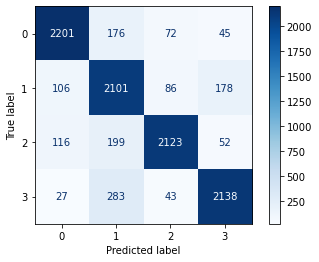

In [16]:
# Check out the raw confusion matrix

preds = stack.predict(X_vec_test)
ConfusionMatrixDisplay.from_estimator(stack, X_vec_test, y_test, cmap='Blues');

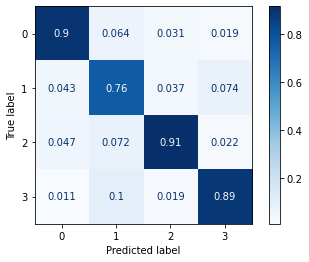

In [18]:
# Check out the prediction-normalized confusion matrix

preds = stack.predict(X_vec_test)
ConfusionMatrixDisplay.from_estimator(stack, X_vec_test, y_test, cmap='Blues', normalize = 'pred');

**Conclusions:**
- Our train/test scores didn't drop too much with the 4-class model, and nothing in the confusion matrix particularly sticks out as problematic.
- This is a good sign for generalizing our model to more than 2 genres!

**FINAL NOTES**:
- Our experiments in unsupervised learning and dimensionality reduction produced unsatisfactory results - more research needed to see if either might be useful.
- Generalizing our model to 4 genres instead of 2 produced fairly positive results - some work may be needed to optimize the model for this more complex case.
- To view the production model results, go [here](./05_results.ipynb).